# Library Setup
For training it is used lava-dl package release 0.2.0 (available for download here https://github.com/lava-nc/lava-dl/releases)

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
  gdrive_path = '/content/gdrive/MyDrive/'  # Define Google Drive path in Colab
except:
  pass

!pip install /content/gdrive/MyDrive/Library/lava-dl-main.zip -q

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

import scipy.io as sio
import os
import requests
import sys

# Dataset Prep
This example utilizes S1_E1_A1.mat file of Ninapro DB5 Dataset (included in the archive s1.zip, available for download here https://ninapro.hevs.ch/instructions/DB5.html)

In [3]:
#@title EMG data extraction

path = '/content/gdrive/MyDrive/Ninapro/Dataset/s1/'
mat_contents = sio.loadmat(path+'S1_E1_A1.mat')

emg = mat_contents['emg']
stimulus = mat_contents['stimulus']
repetition = mat_contents['repetition']
exercise = mat_contents['exercise']

print('emg.shape:', emg.shape)
print('stimulus.shape:', stimulus.shape)
print('repetition.shape:', repetition.shape)
print('exercise.shape:', exercise.shape)

moments = np.convolve(repetition[:,0],[-1,+1])
moments[np.where(moments!=0)] = 1
index = np.where(moments == 1)
'''
num_channels = emg.shape[1]
fig, axs = plt.subplots(num_channels + 1, 1, figsize=(14, 3 * (num_channels + 1)))
t = range(0,40000)

# Plot the main signals in the first subplot
axs[0].plot(stimulus[t], label='stimulus')
axs[0].plot(repetition[t], label='repetition')
axs[0].plot(moments[t], label='new rep signal')
axs[0].set_title("Stimulus, Repetition, New Rep Signal")
axs[0].legend()

# Plot each channel of the EMG signal in a separate subplot
for i in range(num_channels):
    axs[i + 1].plot(emg[t, i])
    axs[i + 1].set_title(f"EMG Channel {i + 1}")
    axs[i + 1].set_ylim(-100,+100)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
'''
print()

emg.shape: (130267, 16)
stimulus.shape: (130267, 1)
repetition.shape: (130267, 1)
exercise.shape: (1, 1)



## EMG Delta Modulation

In [4]:
#@title Delta Modulation Definition

def new_delta_modulation(input,delta,output):
  prev = np.zeros(input[0].shape)
  for j in range(0,input.shape[0]):
    pos_spike = input[j] > (prev + delta); #print(input[j]);
    neg_spike = input[j] < (prev - delta); #print(prev); print(delta); print('__________________________')

    prev[pos_spike] = prev[pos_spike] + delta[pos_spike]
    prev[neg_spike] = prev[neg_spike] - delta[neg_spike]

    #output[j] = np.insert(neg_spike, 0, pos_spike, axis=0)
    output[j,0::2] = pos_spike
    output[j,1::2] = neg_spike

In [5]:
#@title Delta Modulation Computation

# emg derivatives can be used as input of the SNN, not used in this example.
emg_d = np.diff(emg,axis=0)
emg_d = np.insert(emg_d, 0, emg[0,:], axis=0) # hw transient
#emg_d = np.array([np.convolve(row, np.ones(2)*0.5, mode='same') for row in emg_d]) # if enabled emg_d is filtered mav-2
emg_dd = np.diff(emg_d,axis=0)
emg_dd = np.insert(emg_dd, 0, emg_d[0,:], axis=0) # hw transient
emg_ddd = np.diff(emg_dd,axis=0)
emg_ddd = np.insert(emg_ddd, 0, emg_dd[0,:], axis=0) # hw transient

#emg_and_d = np.concatenate((emg,emg_d),axis=1)
emg_and_d = emg

print('emg.shape:', emg.shape)
print('emg_d.shape:', emg_d.shape)
print('emg_dd.shape:', emg_dd.shape)
print('emg_and_d.shape:', emg_and_d.shape)

# different delta per channel
percentage = 0.1

delta_factors_emg = ((emg_d.max(0)*0.05).round()).astype(int)
delta_factors_emg = delta_factors_emg[:,None]

delta_factors_demg = ((emg_dd.max(0)*percentage).round()).astype(int)
delta_factors_demg = delta_factors_demg[:,None]

delta_factors_ddemg = ((emg_ddd.max(0)*percentage).round()).astype(int)
delta_factors_ddemg = delta_factors_ddemg[:,None]

#delta_factors_dddemg = ((emg_d.max(0)*percentage).round()).astype(int)
#delta_factors_dddemg = delta_factors_emg[:,None]

#delta = np.concatenate((delta_factors_emg, delta_factors_demg),axis=0)[:,0]
delta = delta_factors_emg[:,0]

emg_spike = np.zeros((emg_and_d.shape[0],2*emg_and_d.shape[1]))
new_delta_modulation(emg_and_d,delta,emg_spike)
print('emg_spike.shape:', emg_spike.shape)

emg.shape: (130267, 16)
emg_d.shape: (130267, 16)
emg_dd.shape: (130267, 16)
emg_and_d.shape: (130267, 16)
emg_spike.shape: (130267, 32)


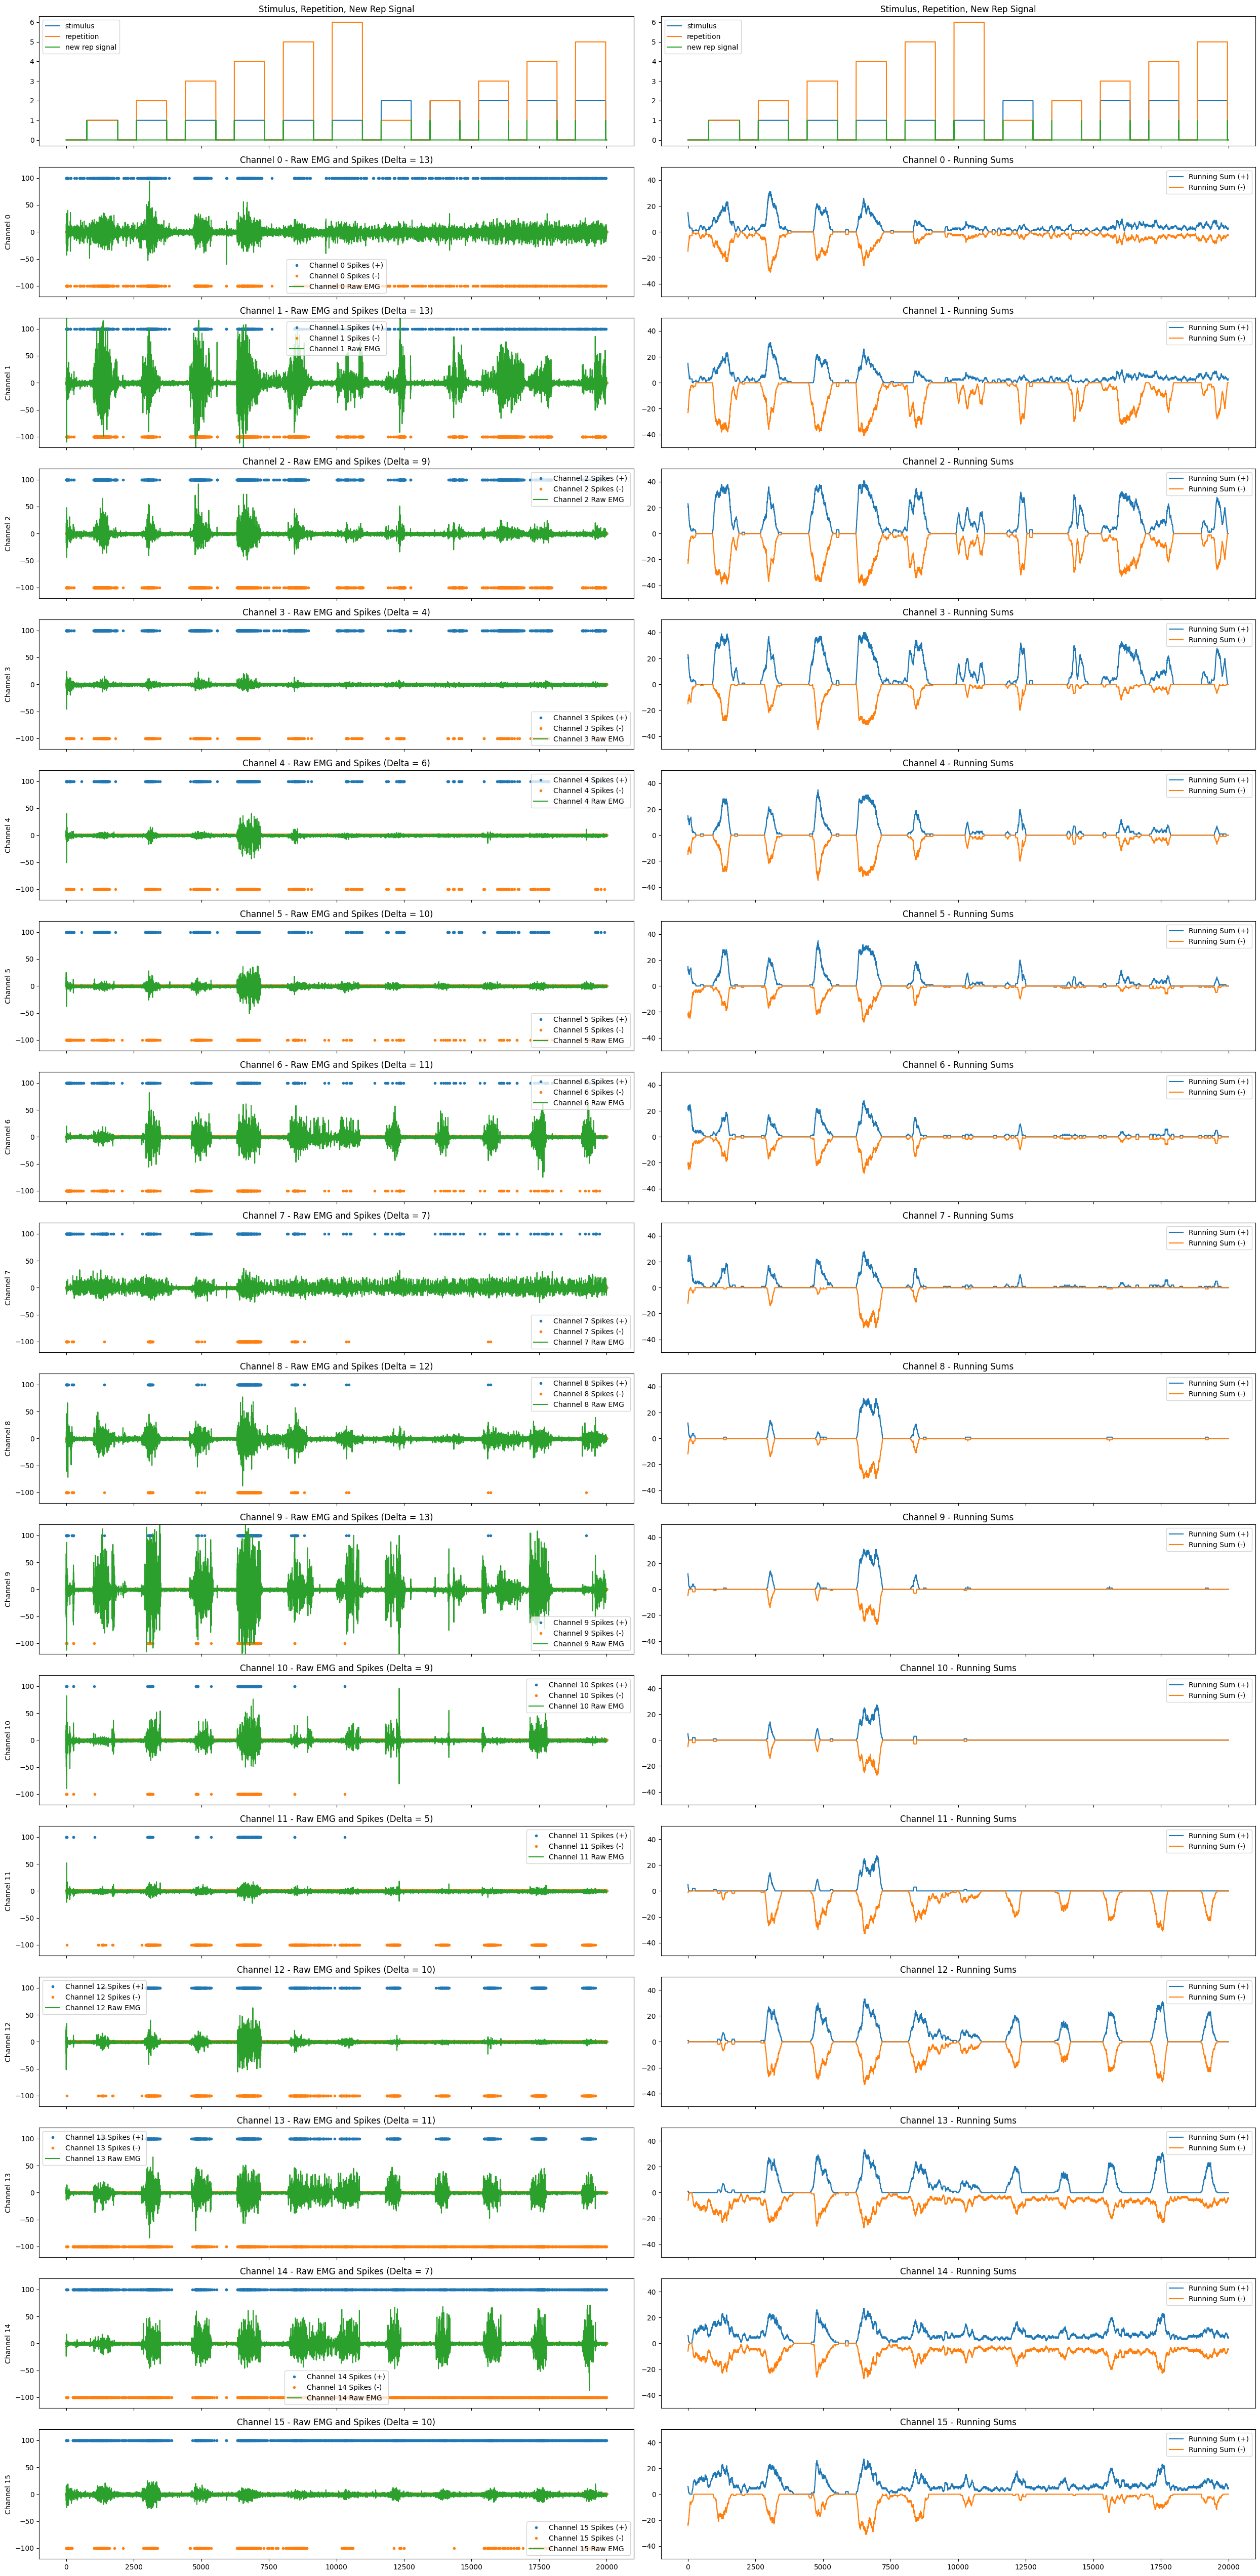

In [6]:
#@title emg_spike visualization
t=range(0,20000)
window_size=100
def running_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

num_channels = emg.shape[1]
nc = int(emg_and_d.shape[1]/emg.shape[1]) # number of components

fig, axs = plt.subplots(num_channels*nc+1, 2, figsize=(25, 3 * (num_channels*nc+1)), sharex=True)

# Plot the main signals in the first subplot
axs[0,0].plot(stimulus[t], label='stimulus')
axs[0,0].plot(repetition[t], label='repetition')
axs[0,0].plot(moments[t], label='new rep signal')
axs[0,0].set_title("Stimulus, Repetition, New Rep Signal")
axs[0,0].legend()

axs[0,1].plot(stimulus[t], label='stimulus')
axs[0,1].plot(repetition[t], label='repetition')
axs[0,1].plot(moments[t], label='new rep signal')
axs[0,1].set_title("Stimulus, Repetition, New Rep Signal")
axs[0,1].legend()

# Loop through each channel
for channel in range(0,num_channels*nc,nc):

    label_type = "Raw EMG" if channel < num_channels else "d(EMG)"

    # Raw EMG and spikes
    axs[channel+1, 0].plot(emg_spike[t, channel] * 100, '.', label=f'Channel {channel} Spikes (+)')
    axs[channel+1, 0].plot(emg_spike[t, channel + 1] * -100, '.', label=f'Channel {channel} Spikes (-)')
    axs[channel+1, 0].plot(emg_and_d[t, channel], linestyle='-', label=f'Channel {channel} {label_type}')

    axs[channel+1, 0].set_title(f"Channel {channel} - {label_type} and Spikes (Delta = {delta[channel]})")
    axs[channel+1, 0].legend()
    axs[channel+1, 0].set_ylim(-120, 120)
    axs[channel+1, 0].set_ylabel(f'Channel {channel}')

    # Running averages
    running_avg_pos = running_average(emg_spike[:, channel] * window_size, window_size)
    running_avg_neg = running_average(emg_spike[:, channel + 1] * -window_size, window_size)
    axs[channel+1, 1].plot(running_avg_pos[:len(t)], label="Running Sum (+)")
    axs[channel+1, 1].plot(running_avg_neg[:len(t)], label="Running Sum (-)")
    axs[channel+1, 1].set_title(f"Channel {channel} - Running Sums")
    axs[channel+1, 1].legend()
    axs[channel+1, 1].set_ylim(-50, 50)
# Adjust layout for clarity
plt.tight_layout()
plt.show()

## Data Segmentation

In [7]:
#@title Continuous classification data segmentation

subjects = ['s1']
movements = 12
stimulus_delay = 0 # delay introduced between movement hint and stimulus for trainin
nonZero = True
newZero = 0.0
newOne  = 40.0

moments = np.convolve(repetition[:,0],[-1,+1]) # track where repetition number changes
moments[np.where(moments!=0)] = 1 # set every change point to 1
index = np.where(moments == 1)[0] # identify change points

# window length function
def window_length_fun(k1,k2):
  window = 0
  for j in range(movements):
      if(index[j*movements+k2-1]-index[j*movements+k1] > window):
        window = index[j*movements+k2-1]-index[j*movements+k1]
  return window

# window lengths
training_window_length = window_length_fun(k1=0,k2=movements)
#training_window_length = window_length_fun(k1=0,k2=8)
#validation_window_length = window_length_fun(k1=8,k2=10)
#testing_window_length = window_length_fun(k1=10,k2=movements)

print('training_window_length = ' + str(training_window_length))
#print('validation_window_length = ' + str(validation_window_length))
#print('testing_window_length = ' + str(testing_window_length))

# window segmentation
def get_dataset(window_length,k1,k2,stimulus_delay):

  window = np.zeros((movements,window_length,emg_spike.shape[1]))
  label  = np.zeros((movements,window_length,movements))
  zero_padding = []

  for i in range(movements):
      i1 = index[i*movements+k1]
      i2 = index[i*movements+k2-1]
      l = i2-i1
      diff = window_length - l
      window[i,diff:,:] = emg_spike[i1:i2,:]
      zero_padding.append(diff)

      dummy = stimulus[i1:i2] # stimulus window
      i1,_ = np.where(dummy == (i+1)) # look for movements index
      i1 = i1 + diff + stimulus_delay # left zero padding + delay
      limit = label.shape[1]
      i1 = i1[i1<limit] # keep only samples that do not go above i2
      # label[i,i1,:] = -1 # other labels set to -1 here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      label[i,i1,i] = 1 # set to 1 neurons

  return window, label, zero_padding

training_window, training_label, training_padding = get_dataset(training_window_length,k1=0,k2=movements,stimulus_delay=stimulus_delay)
#training_window, training_label, training_padding = get_dataset(training_window_length,k1=0,k2=8,stimulus_delay=stimulus_delay)
#validation_window, validation_label, validation_padding = get_dataset(validation_window_length,k1=8,k2=10,stimulus_delay=stimulus_delay)
#testing_window, testing_label, testing_padding = get_dataset(testing_window_length,k1=10,k2=movements,stimulus_delay=stimulus_delay)

print('training_window.shape = ' + str(training_window.shape))
print('training_label.shape = ' + str(training_label.shape))
#print('validation_window.shape = ' + str(validation_window.shape))
#print('validation_label.shape = ' + str(validation_label.shape))
#print('testing_window.shape = ' + str(testing_window.shape))
#print('testing_label.shape = ' + str(testing_label.shape))

# Set output neurons' potential to newZero and newOne,
# keep zero padding portion equal to zero
if nonZero:

  for i, padding in enumerate(training_padding):
        zeros = (training_label[i, :, :] == 0)
        ones = (training_label[i, :, :] == 1)
        neg = (training_label[i, :, :] == -1)
        training_label[i, zeros] = newZero
        training_label[i, ones] = newOne
        training_label[i, neg] = -newOne
        training_label[i, 0:padding, :] = 0 # set 0 padding to zero again
'''
  for i, padding in enumerate(validation_padding):
        zeros = (validation_label[i, :, :] == 0)
        ones = (validation_label[i, :, :] == 1)
        validation_label[i, zeros] = newZero
        validation_label[i, ones] = newOne
        validation_label[i, 0:padding, :] = 0 # set 0 padding to zero again

  for i, padding in enumerate(testing_padding):
        zeros = (testing_label[i, :, :] == 0)
        ones = (testing_label[i, :, :] == 1)
        testing_label[i, zeros] = newZero
        testing_label[i, ones] = newOne
        testing_label[i, 0:padding, :] = 0 # set 0 padding to zero again
'''
print()

training_window_length = 10828
training_window.shape = (12, 10828, 32)
training_label.shape = (12, 10828, 12)



In [8]:
# set label of the same finger = -newOne and also of the next

m = 1

for i in range(0,8,4):
  training_label[i,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
  training_label[i,np.where(training_label[i,:,i]==newOne),i+2] = -m*newOne
  training_label[i,np.where(training_label[i,:,i]==newOne),i+3] = -m*newOne

  training_label[i+1,np.where(training_label[i,:,i]==newOne),i] = -m*newOne
  training_label[i+1,np.where(training_label[i,:,i]==newOne),i+2] = -m*newOne
  training_label[i+1,np.where(training_label[i,:,i]==newOne),i+3] = -m*newOne

  training_label[i+2,np.where(training_label[i,:,i]==newOne),i] = -m*newOne
  training_label[i+2,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
  training_label[i+2,np.where(training_label[i,:,i]==newOne),i+3] = -m*newOne

  training_label[i+3,np.where(training_label[i,:,i]==newOne),i] = -m*newOne
  training_label[i+3,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
  training_label[i+3,np.where(training_label[i,:,i]==newOne),i+2] = -m*newOne


# thumb has 4 movements
i = 8
training_label[i,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i+2] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i+3] = -m*newOne

i = 9
training_label[i,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i+2] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i-1] = -m*newOne

i = 10
training_label[i,np.where(training_label[i,:,i]==newOne),i+1] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i-2] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i-1] = -m*newOne

i = 11
training_label[i,np.where(training_label[i,:,i]==newOne),i-3] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i-2] = -m*newOne
training_label[i,np.where(training_label[i,:,i]==newOne),i-1] = -m*newOne

# ring flexion (4) get -newOne while middle flexion (2)

training_label[2,np.where(training_label[2,:,2]==newOne),4] = -m*newOne

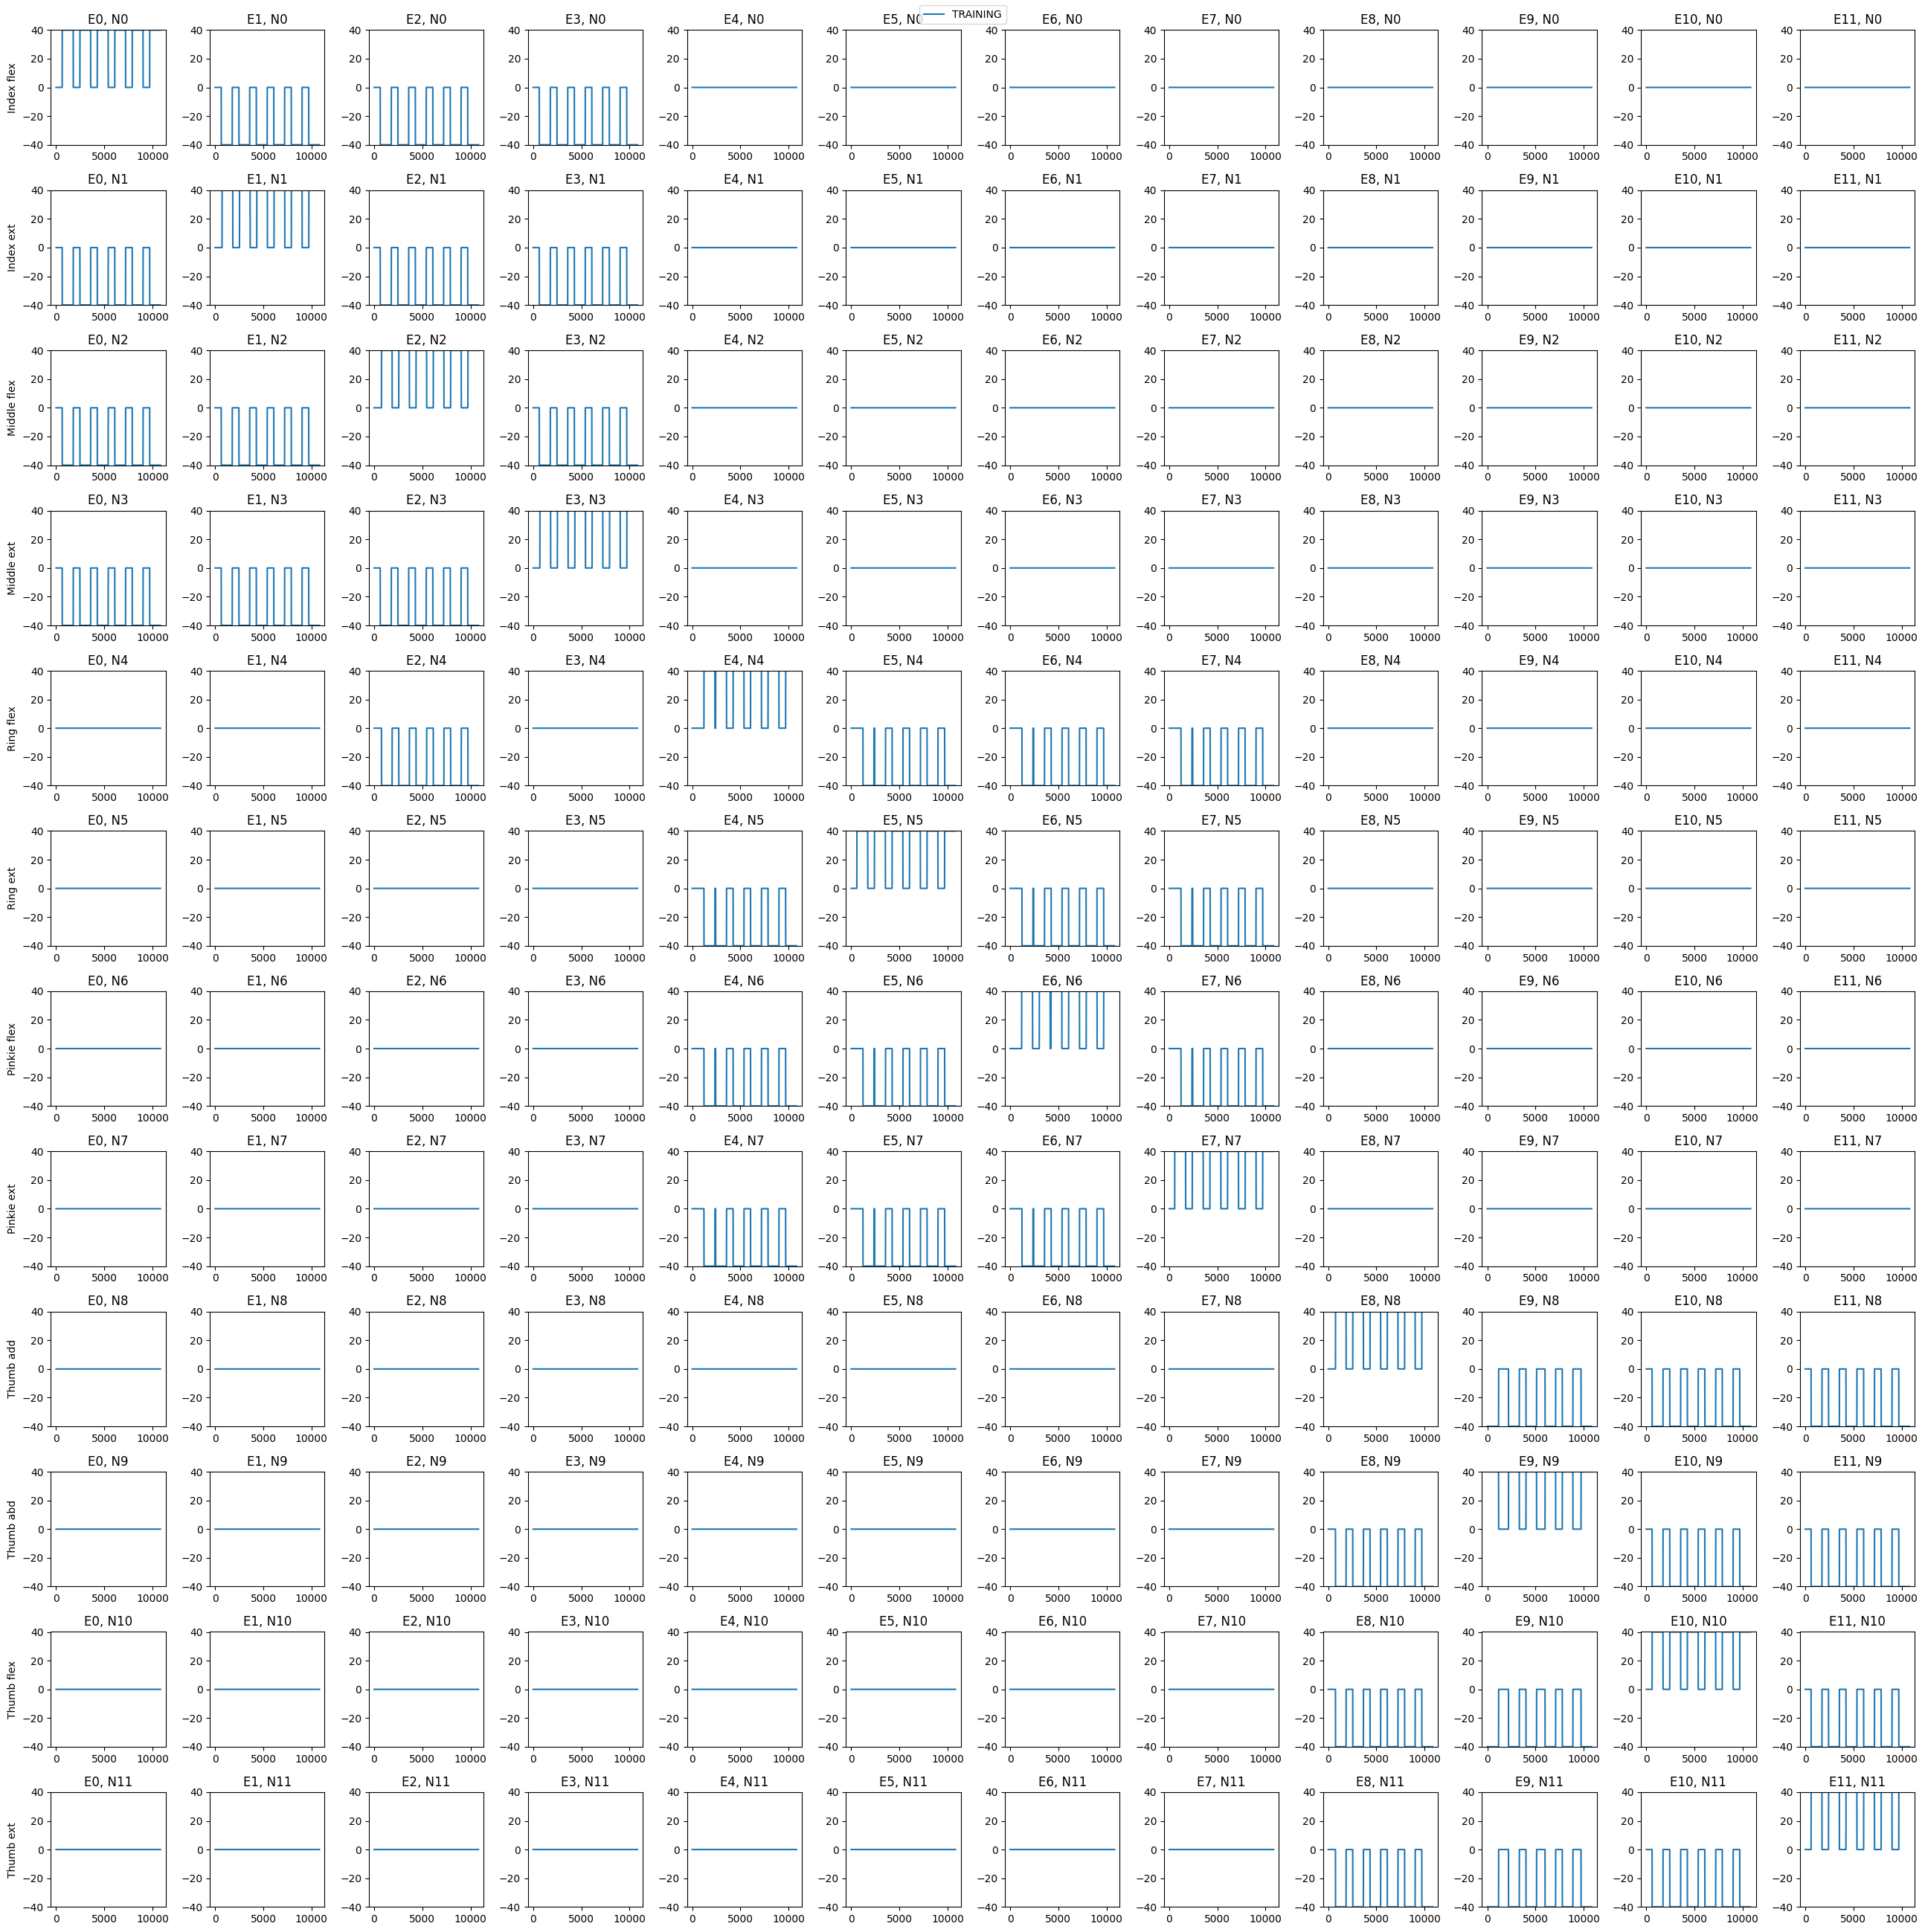

In [9]:
#@title Plot DATASET

fig, axs = plt.subplots(movements,movements, figsize=(26, 26))  # 12 rows for subjects, 12 columns for movements
fingers = ['Index flex','Index ext','Middle flex','Middle ext','Ring flex','Ring ext','Pinkie flex','Pinkie ext','Thumb add','Thumb abd','Thumb flex','Thumb ext']
for neurone in range(movements):
    for esercizio in range(movements):

        paziente = 0

        axs[neurone, esercizio].plot(training_label[esercizio, :, neurone], label='TRAINING')
        #axs[neurone, esercizio].plot(2*testing_label[esercizio, :, neurone], label='V')
        #axs[neurone, esercizio].plot(3*validation_label[esercizio, :, neurone], label='TE')  # Assuming 'labels' is defined

        axs[neurone, esercizio].set_title(f'E{esercizio}, N{neurone}')

        axs[neurone, esercizio].set_ylim(-m*newOne,newOne)
    axs[neurone, 0].set_ylabel(fingers[neurone])

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.show()

print()

In [10]:
#@title Dataset class definition

class EMG_Dataset(Dataset):
  """
  A custom dataset class for Electromyography (EMG) data compatible with PyTorch's Dataset interface.

  This class is designed to handle datasets for EMG analysis tasks, providing necessary methods
  to integrate with PyTorch's data loading utilities.

  Args:
  - x: Input data (features), typically EMG signals in a NumPy array or similar format.
  - y: Target data (labels), usually in a NumPy array format.

  Methods:
  - __init__: Initializes the dataset with input and target data.
  - __getitem__: Retrieves a single sample (input-target pair) from the dataset at the specified index.
  - __len__: Returns the total number of samples in the dataset.
  """

  def __init__(self, x, y):
    """
    Initializes the EMG_Dataset instance with input and target data.
    """

    super(EMG_Dataset, self).__init__()
    self.input = x
    self.target = y

  def __getitem__(self, idx):
    """
    Retrieves the input-target pair at the specified index in the dataset.

    Args:
    - idx: Index of the sample to retrieve.

    Returns:
    - A tuple containing the input data (as a float32 tensor) and the target label (as a long tensor) for the specified index.
    """

    y_out = torch.tensor(self.target[idx].astype(np.float32))  # Convert to float32 tensor
    return (
      torch.tensor(self.input[idx].astype(np.float32)),  # Convert input to float32 tensor
      y_out
    )

  def __len__(self):
    """
    Returns the total number of samples in the dataset.
    """

    return len(self.target)  # Return the length of the target data


In [11]:
#@title Fill Dataset class

# Create TensorDatasets
train_dataset = EMG_Dataset(training_window, training_label)
#valid_dataset = EMG_Dataset(validation_window, validation_label)
#test_dataset = EMG_Dataset(testing_window, testing_label)

# Create DataLoaders
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print out some DataLoader details to confirm
print("len(train_dataloader) = ",len(train_dataloader))#, len(valid_dataloader), len(test_dataloader)

len(train_dataloader) =  12


# SNN definition and training

In [ ]:
#@title Slayer network class definition

class Network(torch.nn.Module):
    def __init__(self, N_last):
        super(Network, self).__init__()

        cuba_params = {
                'threshold'     : 0.1,
                'current_decay' : 1,
                'voltage_decay' : 0.01,
                'requires_grad' : True,
            }

        cuba_params_last_layer = {
                'threshold'     : 1e5,
                'current_decay' : 1,
                'voltage_decay' : 0.01,
                'requires_grad' : True,
            }

        self.fc1 = slayer.block.cuba.Dense(cuba_params, emg_spike.shape[1], 64, delay=False)
        self.fc2 = slayer.block.cuba.Dense(cuba_params, 64, 128, delay=False)
        self.fc3 = slayer.block.cuba.Dense(cuba_params, 128, 64, delay=False)
        self.fc4 = slayer.block.cuba.Dense(cuba_params_last_layer, 64, n_last, delay=False)

        self.max_potential = 0
        self.min_potential = 0

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        wegh_spike = self.fc4.synapse.forward(x)
        (I, V) = self.fc4.neuron.dynamics(wegh_spike)

        return V

    def potential_monitor(self, x):
        max_potential_fc1 = 0; max_potential_fc2 = 0; max_potential_fc3 = 0; max_potential_fc4 = 0;
        min_potential_fc1 = 0; min_potential_fc2 = 0; min_potential_fc3 = 0; min_potential_fc4 = 0;
        self.fc1.neuron.persistent_state = True
        self.fc2.neuron.persistent_state = True
        self.fc3.neuron.persistent_state = True
        self.fc4.neuron.persistent_state = True

        print(x.shape)
        y = x[:,:,0]
        y = y[:,:,None]
        print(y.shape)

        for i in range(x.shape[2]-1):

          sys.stdout.write(f"\rProcessing step {i}/{x.shape[2]}")

          y = x[:,:,0:i+1]
          y = self.fc1(y)
          y = self.fc2(y)
          y = self.fc3(y)
          wegh_spike = self.fc4.synapse.forward(y)
          (I, V) = self.fc4.neuron.dynamics(wegh_spike)

          if(self.fc1.neuron.voltage_state.to('cpu').max() > max_potential_fc1):
            max_potential_fc1 = self.fc1.neuron.voltage_state.to('cpu').max()
          if(self.fc2.neuron.voltage_state.to('cpu').max() > max_potential_fc2):
            max_potential_fc2 = self.fc2.neuron.voltage_state.to('cpu').max()
          if(self.fc3.neuron.voltage_state.to('cpu').max() > max_potential_fc3):
            max_potential_fc3 = self.fc3.neuron.voltage_state.to('cpu').max()
          if(self.fc4.neuron.voltage_state.to('cpu').max() > max_potential_fc4):
            max_potential_fc4 = self.fc4.neuron.voltage_state.to('cpu').max()

          if(self.fc1.neuron.voltage_state.to('cpu').min() < min_potential_fc1):
            min_potential_fc1 = self.fc1.neuron.voltage_state.to('cpu').min()
          if(self.fc2.neuron.voltage_state.to('cpu').min() < min_potential_fc2):
            min_potential_fc2 = self.fc2.neuron.voltage_state.to('cpu').min()
          if(self.fc3.neuron.voltage_state.to('cpu').min() < min_potential_fc3):
            min_potential_fc3 = self.fc3.neuron.voltage_state.to('cpu').min()
          if(self.fc4.neuron.voltage_state.to('cpu').min() < min_potential_fc4):
            min_potential_fc4 = self.fc4.neuron.voltage_state.to('cpu').min()

        print('max_potential_fc1 = '+str(max_potential_fc1))
        print('min_potential_fc1 = '+str(min_potential_fc1))
        print('max_potential_fc2 = '+str(max_potential_fc2))
        print('min_potential_fc2 = '+str(min_potential_fc2))
        print('max_potential_fc3 = '+str(max_potential_fc3))
        print('min_potential_fc3 = '+str(min_potential_fc3))
        print('max_potential_fc4 = '+str(max_potential_fc4))
        print('min_potential_fc4 = '+str(min_potential_fc4))


        net.fc1.neuron.persistent_state = False
        net.fc2.neuron.persistent_state = False
        net.fc3.neuron.persistent_state = False
        net.fc4.neuron.persistent_state = False

        monitor = torch.tensor( [[max_potential_fc1, min_potential_fc1], [max_potential_fc2, min_potential_fc2], [max_potential_fc3, min_potential_fc3], [max_potential_fc4, min_potential_fc4]] )
        return monitor

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

def event_rate_loss(x, max_rate = 0.001):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

In [ ]:
#@title Create new training folder

import datetime
data = str(datetime.datetime.now())
data = ((data[0:16].replace(" ", "_")).replace("-","_")).replace(":","_")

trained_folder = '/content/gdrive/MyDrive/Ninapro/Slayer/E1/'

os.makedirs(trained_folder, exist_ok=True)

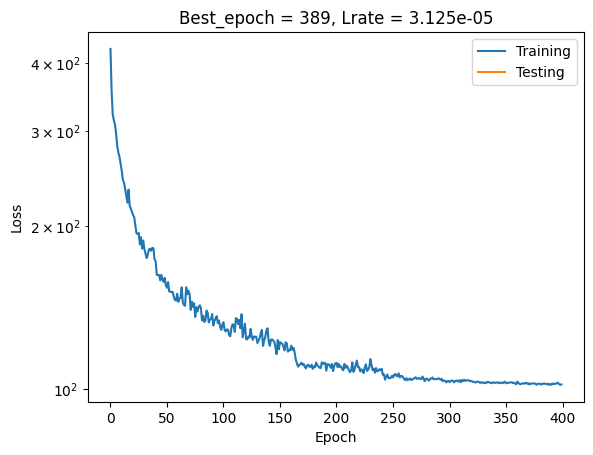

In [ ]:
#@title Slayer training loop

n_last = movements

if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')


net = Network(n_last).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, weight_decay=1e-5)

stats = slayer.utils.LearningStats()

assistant = slayer.utils.Assistant(
        net = net,
        error = lambda output, target: F.mse_loss(output.flatten(), target.flatten()),
        optimizer = optimizer,
        stats = stats,
        count_log = False,
        lam = None
    )

resume_epoch = 0;
last_time = 0
last_change_lr = 0
early_exit = 30
lr_drop_count = 15
lr_decrement = 0.5
epoch = 0
epochs = 400

for epoch in range(epochs):
  # training loop
  for i, (feature, label) in enumerate(train_dataloader):
        feature   = torch.swapaxes(input=feature, axis0=1,axis1=2).to(device)
        label     = torch.swapaxes(input=label, axis0=1,axis1=2).to(device)
        output = assistant.train(feature, label)
        print(f'\r[Epoch {epoch:3d}/{epochs}][{i}/{len(train_dataloader)}] best so far {last_time} {stats}', end='')

  # validation loop
  '''
  for i, (v_feature,v_label) in enumerate(valid_dataloader):
        i = i+1
        v_feature   = torch.swapaxes(input=v_feature, axis0=1,axis1=2).to(device)
        v_label     = torch.swapaxes(input=v_label, axis0=1,axis1=2).to(device)

        output = assistant.test(v_feature, v_label)
        print(f'\r[Epoch {epoch:3d}/{epochs}][{i}/{len(train_dataloader)}] best so far {last_time} {stats}', end='')
  '''

  # check loss on training
  if stats.training.best_loss:
    last_time = epoch
    with open(trained_folder+'/best_model.txt', 'w') as f:
      f.write('%d' %last_time)
      torch.save(net, trained_folder + '/network.pt')

    with open(trained_folder+'/counter.txt', 'w') as f:
      f.write('%d' %epoch)
    with open(trained_folder+'/training_loss.txt', 'w') as f:
      training_loss = stats.training.loss_log
      f.writelines(str(training_loss))
    '''
    with open(trained_folder+'/validation_loss.txt', 'w') as f:
      validation_loss = stats.testing.loss_log
      f.writelines(str(validation_loss))
    '''
  # save training epoch for resume
  torch.save(net, trained_folder + '/network_last.pt')

  # save stats
  stats.update()
  stats.save(trained_folder + '/')

  # lr drop
  if last_time + lr_drop_count == epoch:
    optimizer.param_groups[0]['lr'] *= lr_decrement
    # resume best model
    net = torch.load(trained_folder + '/network.pt', map_location=torch.device(device))

  # early exit
  if last_time + early_exit == epoch:
    print('')
    print('early exit')
    break

  clear_output(wait=True)
  plt.semilogy(stats.training.loss_log, label='Training')
  plt.semilogy(stats.testing.loss_log, label='Testing')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Best_epoch = ' + str(last_time) + ', Lrate = '+str(optimizer.param_groups[0]['lr']))
  plt.legend()
  plt.show()

# Model evaluation

In [ ]:
#@title create new training folder

import datetime
data = str(datetime.datetime.now())
data = ((data[0:16].replace(" ", "_")).replace("-","_")).replace(":","_")

trained_folder = '/content/gdrive/MyDrive/Ninapro/Slayer/E1/'

os.makedirs(trained_folder, exist_ok=True)

In [ ]:
#@title load model
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')

net = torch.load(trained_folder + 'network.pt', map_location=torch.device(device))

net.fc1.synapse.pre_hook_fx = None
net.fc2.synapse.pre_hook_fx = None
net.fc3.synapse.pre_hook_fx = None
net.fc4.synapse.pre_hook_fx = None

Tesla T4


## **Continuous Output**

In [ ]:
#@title Continuous inference
emg_spike_torch = torch.tensor(emg_spike, dtype=torch.float32, device=device)
emg_spike_torch = torch.swapaxes(input=emg_spike_torch, axis0=1,axis1=0)
emg_spike_torch = emg_spike_torch[None,:,:]
continuous_output = net(emg_spike_torch).cpu().detach().numpy()

In [ ]:
#@title Apply comparator to regression output
compared_continuous_output = np.copy(continuous_output)
compared_continuous_output[compared_continuous_output > 0.75*newOne] = newOne
compared_continuous_output[compared_continuous_output <= 0.75*newOne] = newZero

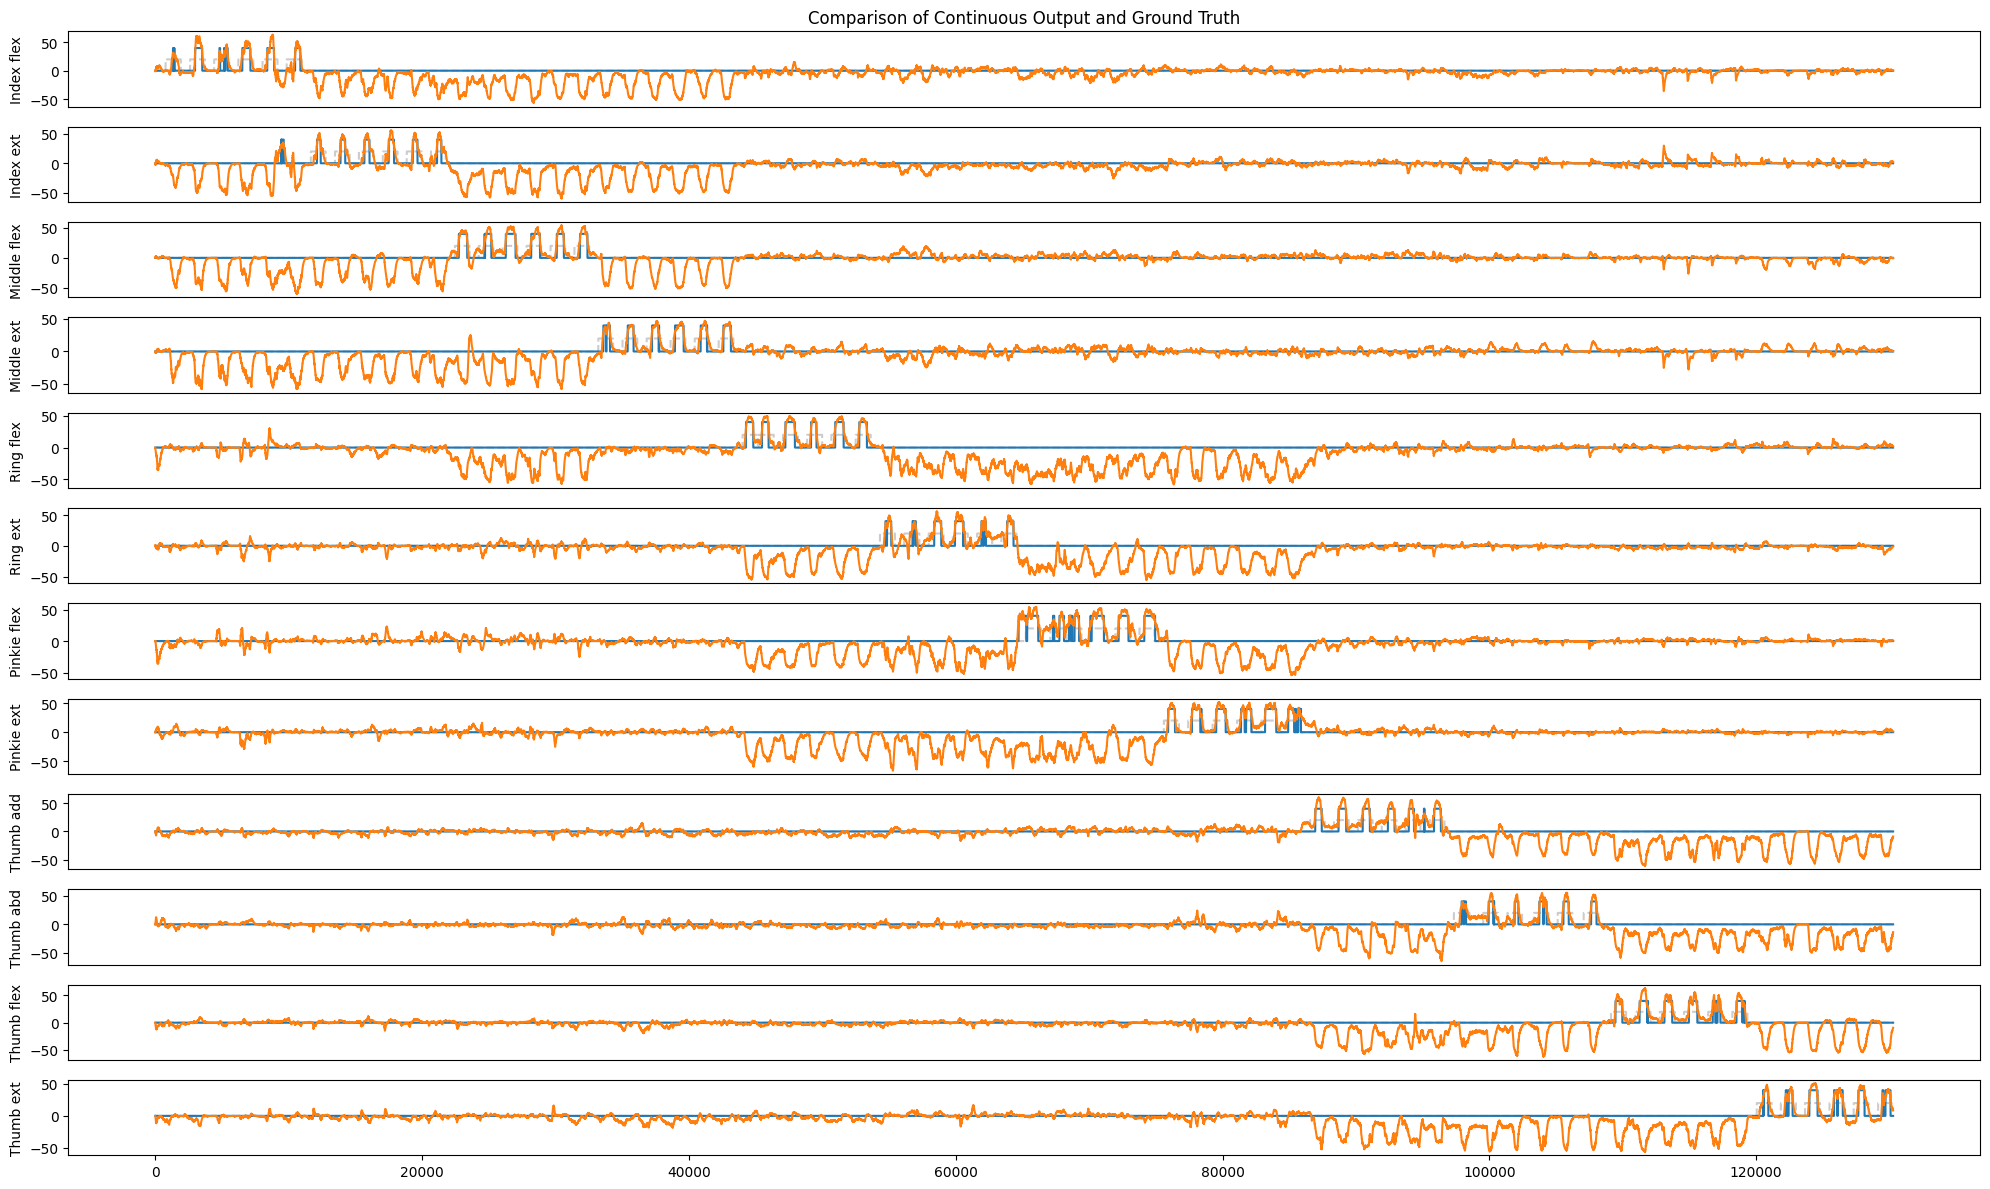

In [ ]:
#@title Plot Continuous Output
fig, axs = plt.subplots(12, 1, figsize=(20, 12))  # 12 rows for subplots
fingers = ['Index flex','Index ext','Middle flex','Middle ext','Ring flex','Ring ext','Pinkie flex','Pinkie ext','Thumb add','Thumb abd','Thumb flex','Thumb ext']
for i in range(12):
  axs[i].plot((stimulus==(i+1))*20, '--', color=(0.8,0.8,0.8), label='Ground Truth')
  axs[i].plot(compared_continuous_output[0, i, ], label='Compared Continuous Output')
  axs[i].plot(continuous_output[0, i, ], label='Continuous Output')
  axs[i].set_ylabel(fingers[i])

  if i < 11:
    axs[i].set_xticks([])  # Hide xticks for all subplots except the last one

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
axs[0].set_title('Comparison of Continuous Output and Ground Truth')
plt.tight_layout()
plt.show()

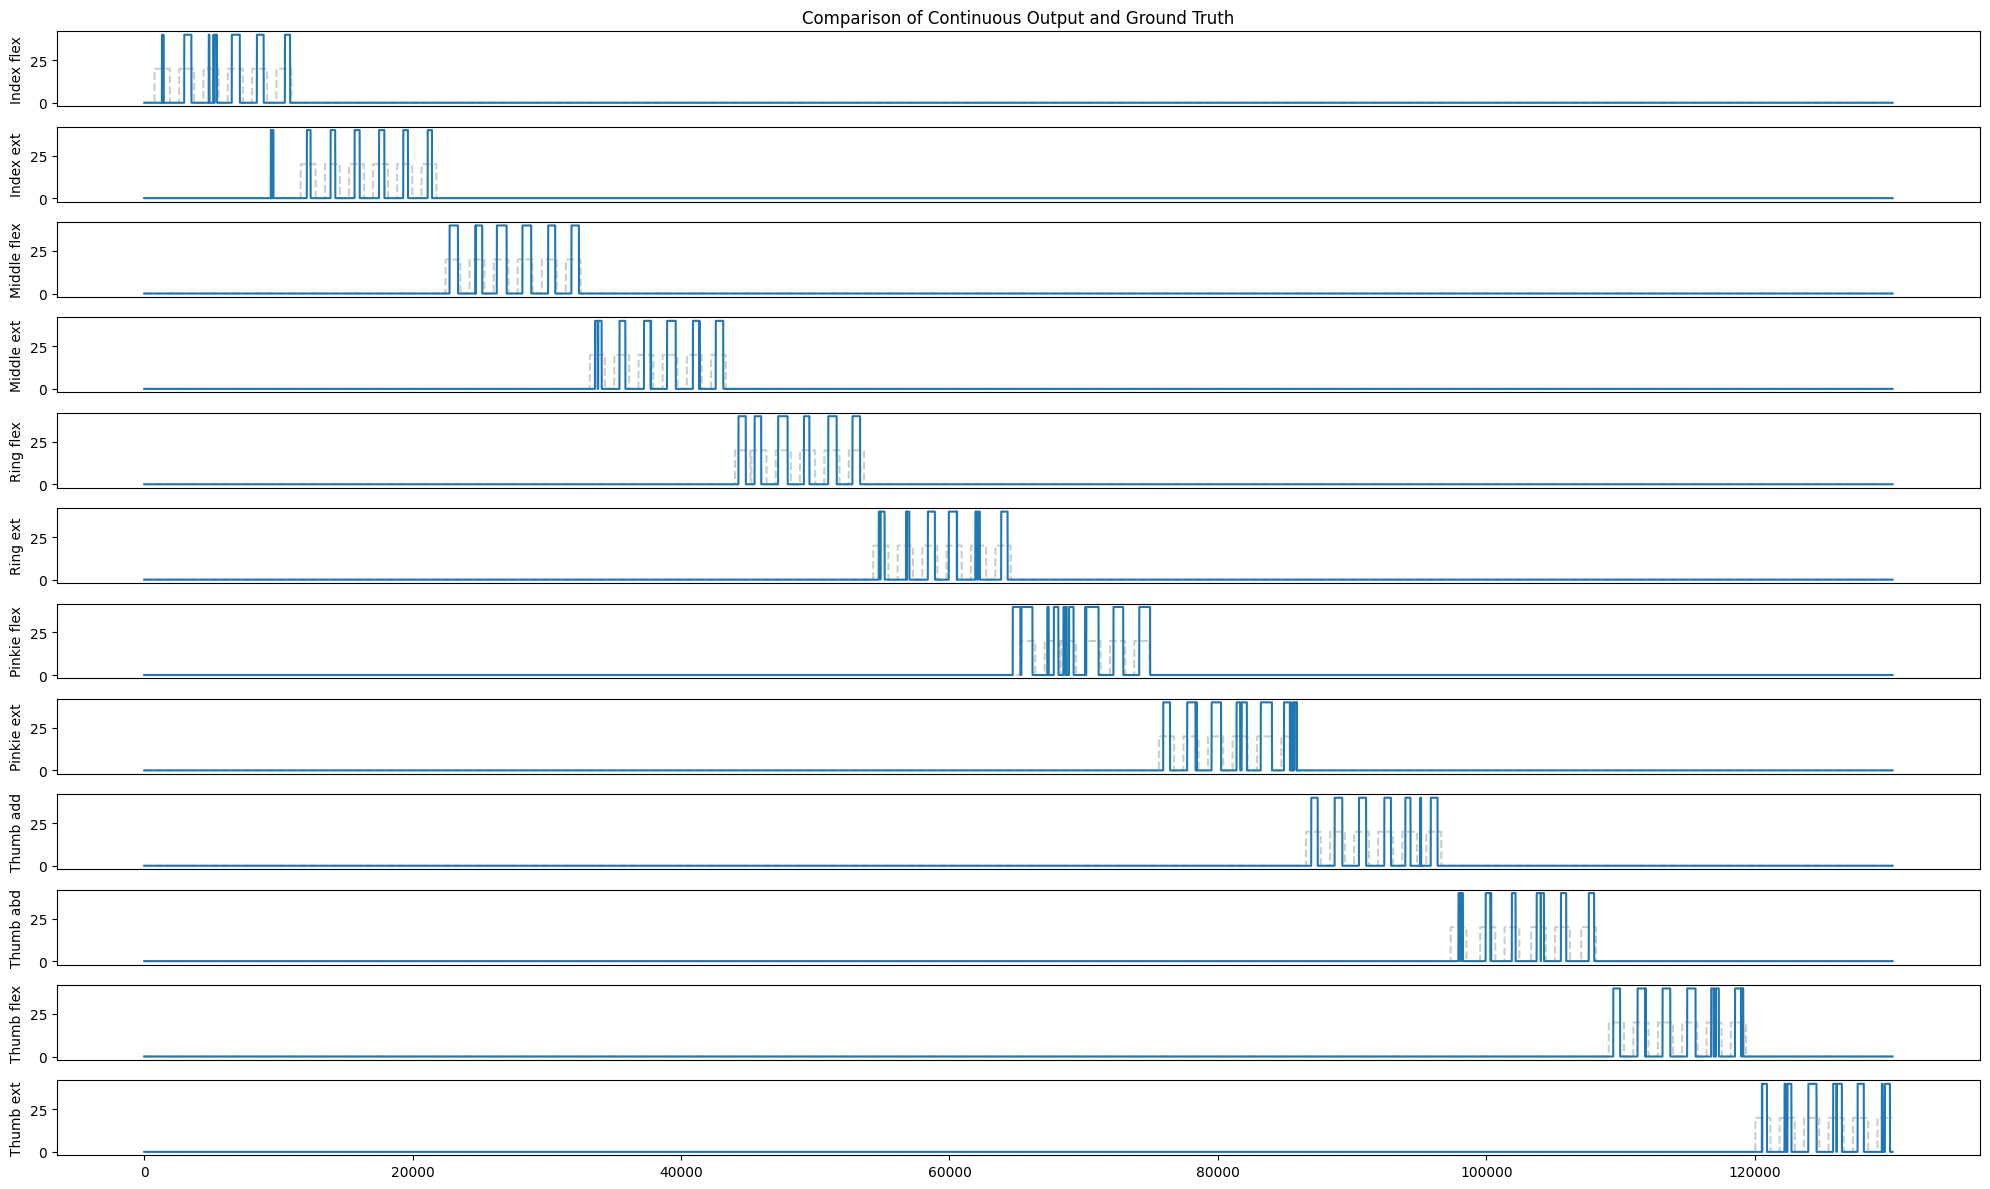

In [ ]:
#@title Plot Continuous Output
fig, axs = plt.subplots(12, 1, figsize=(20, 12))  # 12 rows for subplots
fingers = ['Index flex','Index ext','Middle flex','Middle ext','Ring flex','Ring ext','Pinkie flex','Pinkie ext','Thumb add','Thumb abd','Thumb flex','Thumb ext']
for i in range(12):
  axs[i].plot((stimulus==(i+1))*20, '--', color=(0.8,0.8,0.8), label='Ground Truth')
  axs[i].plot(compared_continuous_output[0, i, ], label='Compared Continuous Output')
  axs[i].set_ylabel(fingers[i])

  if i < 11:
    axs[i].set_xticks([])  # Hide xticks for all subplots except the last one

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
axs[0].set_title('Comparison of Continuous Output and Ground Truth')
plt.tight_layout()
plt.show()

# Model Quantization

In [ ]:
#@title define training path

import datetime
data = str(datetime.datetime.now())
data = ((data[0:16].replace(" ", "_")).replace("-","_")).replace(":","_")

trained_folder = '/content/gdrive/MyDrive/Ninapro/Slayer/E1/'

os.makedirs(trained_folder, exist_ok=True)

In [ ]:
#@title load model

if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')

net = torch.load(trained_folder + 'network.pt', map_location=torch.device(device))

net.fc1.synapse.pre_hook_fx = None
net.fc2.synapse.pre_hook_fx = None
net.fc3.synapse.pre_hook_fx = None
net.fc4.synapse.pre_hook_fx = None

Tesla T4


In [ ]:
#@title Neuron Voltage Observer during Continuous Inference
emg_spike_torch = torch.tensor(emg_spike[20000:25000,:], dtype=torch.float32, device=device)
emg_spike_torch = torch.swapaxes(input=emg_spike_torch, axis0=1,axis1=0)
emg_spike_torch = emg_spike_torch[None,:,:]
monitor = net.potential_monitor(emg_spike_torch)#.cpu().detach().numpy()

torch.Size([1, 32, 5000])
torch.Size([1, 32, 1])
Processing step 4998/5000max_potential_fc1 = tensor(0.0938)
min_potential_fc1 = tensor(-108.4966)
max_potential_fc2 = tensor(0.0938)
min_potential_fc2 = tensor(-138.4333)
max_potential_fc3 = tensor(0.0938)
min_potential_fc3 = tensor(-283.5879)
max_potential_fc4 = tensor(52.0969)
min_potential_fc4 = tensor(-57.3760)


In [ ]:
#@title Fixed point information

w1 = net.fc1.synapse.weight[:,:,0,0,0]
w2 = net.fc2.synapse.weight[:,:,0,0,0]
w3 = net.fc3.synapse.weight[:,:,0,0,0]
w4 = net.fc4.synapse.weight[:,:,0,0,0]

w1max = torch.max(w1).cpu().detach()
w1min = torch.min(w1).cpu().detach()
w2max = torch.max(w2).cpu().detach()
w2min = torch.min(w2).cpu().detach()
w3max = torch.max(w3).cpu().detach()
w3min = torch.min(w3).cpu().detach()
w4max = torch.max(w4).cpu().detach()
w4min = torch.min(w4).cpu().detach()

print('Floating point weight MAX and MIN')
print(w1max,w1min)
print(w2max,w2min)
print(w3max,w3min)
print(w4max,w4min)
print()


scale_w1 = 127/max(w1max,abs(w1min))
scale_w2 = 127/max(w2max,abs(w2min))
scale_w3 = 127/max(w3max,abs(w3min))
scale_w4 = 127/max(w4max,abs(w4min))

print("Scale factor per layer")
print(scale_w1)
print(scale_w2)
print(scale_w3)
print(scale_w4)
print()

scale = torch.tensor([scale_w1,scale_w2,scale_w3,scale_w4])

fixed_point_voltage_snn1 = monitor[0,:]*scale[0]
fixed_point_voltage_snn2 = monitor[1,:]*scale[1]
fixed_point_voltage_snn3 = monitor[2,:]*scale[2]
fixed_point_voltage_snn4 = monitor[3,:]*scale[3]

print("Fixed point voltage Max and Min")
print(fixed_point_voltage_snn1)
print(fixed_point_voltage_snn2)
print(fixed_point_voltage_snn3)
print(fixed_point_voltage_snn4)
print()

Floating point weight MAX and MIN
tensor(0.4709) tensor(-0.6347)
tensor(0.6417) tensor(-0.6945)
tensor(0.5039) tensor(-1.1115)
tensor(0.2595) tensor(-0.2435)

Scale factor per layer
tensor(200.0881)
tensor(182.8607)
tensor(114.2569)
tensor(489.4218)

Fixed point voltage Max and Min
tensor([ 1.8758e+01, -2.1709e+04])
tensor([ 1.7143e+01, -2.5314e+04])
tensor([ 1.0712e+01, -3.2402e+04])
tensor([ 25497.3730, -28081.0566])

2**15 =  32768  => voltage @ 32 bit


# Quantized SNN storage
This object will be the input for the second script SYNtzulu-HW-file-generator

In [ ]:
#@title Deployment class definition: to save the quantized model and deployment information.
class Deployment:

    layers = 4
    fs = 0
    data_width_in_byte = 0
    classifier = 0
    window_in_seconds = 0
    classification_stride_in_seconds = 0
    encoding = "delta"
    delta = 0.0

    def __init__(self,input_encoding,input_network,n1,n2,n3,n4,N):
      self.input_encoding = input_encoding
      self.input_network = input_network
      self.n1 = n1
      self.n2 = n2
      self.n3 = n3
      self.n4 = n4
      self.N  = N

    def set_weights(self,w1,w2,w3,w4):
      self.set_weights_helper(w1,1,self.input_network,self.n1)
      self.set_weights_helper(w2,2,self.n1,self.n2)
      self.set_weights_helper(w3,3,self.n2,self.n3)
      self.set_weights_helper(w4,4,self.n3,self.n4)

    def set_weights_helper(self,w,i,d1,d2):
      if not torch.is_tensor(w):
            raise TypeError("weight_" + str(i) + " must be a numpy")
      dim = w.shape
      if not dim == (d2,d1):
            raise TypeError('weight_' + str(i) + ' must be ' + str((d2,d1)) + ' but is ' + str(dim))
      if i==1:
       self.weights_1 = w
      elif i==2:
        self.weights_2 = w
      elif i==3:
        self.weights_3 = w
      elif i==4:
        self.weights_4 = w

    def set_current_decay(self,idecay):
      if not torch.is_tensor(idecay):
            raise TypeError("current_decay must be torch")
      dim = idecay.shape
      if not dim[0] == self.layers:
            raise TypeError('Current_decay must contain 4 elements')
      self.current_decay = idecay

    def set_voltage_decay(self,vdecay):
      if not torch.is_tensor(vdecay):
            raise TypeError("voltage_decay must be torch")
      dim = vdecay.shape
      if not dim[0] == self.layers:
            raise TypeError('Voltage_decay must contain 4 elements')
      self.voltage_decay = vdecay

    def set_threshold(self,threshold):
      if not torch.is_tensor(threshold):
            raise TypeError("threshold must be torch")
      dim = threshold.shape
      if not dim[0] == self.layers:
            raise TypeError('Threshold must contain 4 elements')
      self.threshold = threshold

    def set_scale(self,scale):
      if not torch.is_tensor(scale):
            raise TypeError("scale must be torch")
      dim = scale.shape
      if not dim[0] == self.layers:
            raise TypeError('Scale must contain 4 elements')
      self.scale = scale

    def set_delay_support(self,d,n,i):
      if not torch.is_tensor(d):
            raise TypeError("Delay_" + str(i) + " must be torch")
      dim = d.shape
      if not dim[0] == n:
            raise TypeError("Delay_" + str(i) +  " must contain " + str(n) + " elements")
      if torch.is_floating_point(d):
            raise TypeError("Delay_" + str(i) +  " must be dtype=torch.int32")
      if i==1:
       self.delay_1 = d
      elif i==2:
        self.delay_2 = d
      elif i==3:
        self.delay_3 = d
      elif i==4:
        self.delay_4 = d

    def set_delay(self,d1,d2,d3,d4):
      self.set_delay_support(d1,self.n1,1)
      self.set_delay_support(d2,self.n2,2)
      self.set_delay_support(d3,self.n3,3)
      self.set_delay_support(d4,self.n4,4)

    def set_input_encoding(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Test_vector must be torch")
      dim = vector.shape
      if not dim == (self.input_encoding,self.N):
            raise TypeError('Input encoding must be torch ' + str((self.input_encoding,self.N)) + ' but is ' + str(dim))
      self.test_vector_encoding = vector

    def set_input_network(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Test_vector must be torch")
      dim = vector.shape
      if not dim == (self.input_network,self.N):
            raise TypeError('input network must be torch ' + str((self.input_network,self.N)) + ' but is ' + str(dim))
      self.test_vector_snn = vector

    def set_output(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Target_vector must be torch")
      dim = vector.shape
      if not dim == (self.n4,self.N):
            raise TypeError('Target_vector must be torch ' + str((self.n4,self.N)) + ' but is ' + str(dim))
      self.target_vector = vector

In [ ]:
#@title model reload and test vector computation
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')

trained_folder = '/content/gdrive/MyDrive/Ninapro/Slayer/E1/'
os.makedirs(trained_folder, exist_ok=True)

net = torch.load(trained_folder + '/network.pt', map_location=torch.device(device))

#@title Continuous inference
emg_spike_torch = torch.tensor(emg_spike[0:20000,:], dtype=torch.float32, device=device)
emg_spike_torch = torch.swapaxes(input=emg_spike_torch, axis0=1,axis1=0)
emg_spike_torch = emg_spike_torch[None,:,:]
continuous_output = net(emg_spike_torch).cpu().detach().numpy()

Tesla T4


In [ ]:
#@title Object initialization
input_encoding = emg.shape[1]        # number of inputs of the encoding
input_network =  emg_spike.shape[1]  # number of inputs of the SNN
n1    = 64  # neurons L1
n2    = 128 # neurons L2
n3    = 64  # neurons L3
n4    = 12  # neurons L4
N     = int(emg_spike_torch.shape[2]) # test number of samples

deploy = Deployment(input_encoding,input_network,n1,n2,n3,n4,N)

# weights: torch(#neurons, #input_network)
w1 = net.fc1.synapse.weight[:,:,0,0,0]
w2 = net.fc2.synapse.weight[:,:,0,0,0]
w3 = net.fc3.synapse.weight[:,:,0,0,0]
w4 = net.fc4.synapse.weight[:,:,0,0,0]

w1 = w1.cpu().detach()
w2 = w2.cpu().detach()
w3 = w3.cpu().detach()
w4 = w4.cpu().detach()

deploy.set_weights(w1,w2,w3,w4)

# current and voltage decay, threshold, weight quantization scale factors
# it can be used a torch array of 4 elements if the parameter is the same for all neurons in the layer,
# or a torch(4,#neuroni) if the parameter is per neuron
deploy.set_current_decay(torch.tensor([net.fc1.neuron.current_decay.detach().cpu().numpy()[0], net.fc2.neuron.current_decay.detach().cpu().numpy()[0], net.fc3.neuron.current_decay.detach().cpu().numpy()[0], net.fc4.neuron.current_decay.detach().cpu().numpy()[0]]))
deploy.set_voltage_decay(torch.tensor([net.fc1.neuron.voltage_decay.detach().cpu().numpy()[0], net.fc2.neuron.voltage_decay.detach().cpu().numpy()[0], net.fc3.neuron.voltage_decay.detach().cpu().numpy()[0], net.fc4.neuron.voltage_decay.detach().cpu().numpy()[0]]))
deploy.set_threshold(torch.tensor([net.fc1.neuron.threshold,net.fc2.neuron.threshold,net.fc3.neuron.threshold,net.fc4.neuron.threshold]))
deploy.set_scale(scale)

# axonal delay
# accept one array per layer, pass zero if the delay is zero
z1 = torch.zeros(n1).int()
z2 = torch.zeros(n2).int()
z3 = torch.zeros(n3).int()
z4 = torch.zeros(n4).int()
deploy.set_delay(z1,z2,z3,z4)

# encoding slot input: torch(input_encoding, number of samples)
deploy.set_input_encoding(torch.swapaxes(input = torch.tensor(emg[0:N,:]), axis0 = 1, axis1 = 0))
# SNN input/encoding slot output: torch(input_network, number of samples)
deploy.set_input_network(torch.swapaxes(input = torch.tensor(emg_spike[0:N,:]), axis0 = 1, axis1 = 0))
# SNN output torch(n4, number of samples)
deploy.set_output(torch.tensor(continuous_output[0,:,0:N]))

deploy.fs_hz = 200
deploy.data_width_in_byte = 1
deploy.classifier = False
deploy.window_in_seconds = 0.5
deploy.classification_stride_in_seconds = 0.1
deploy.encoding = "delta-modulation"
deploy.delta    = delta

In [ ]:
#@title Store Object
import pickle

file = open('continuous_sEMG_classification.obj', 'wb')
pickle.dump(deploy,file)
file.close()